In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import find_peaks
from matplotlib.dates import date2num  
from mpl_toolkits import mplot3d


# Load and Transform data

In [2]:
df = pd.read_csv('dataset_2019041.csv',header=None)
# provide column names
df.columns = ['x', 'y' , 'z' , 'timestamp' , 'activity' , 'user']
# cast colum to timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(df['timestamp'])

# Create List of Users and Activities

In [3]:
all_users=  [1,2,4,5,6,7]
all_activities = [i+1 for i in range(19)]

In [4]:
def getDurations(df,users,activities):
    ############ Duration of Each Activity for each user ###############
    durations = pd.DataFrame(columns=['User','Activity','Date','Duration'])
    count = 0
    # each user in list
    for user in users:
        # each activity in list
        for act in activities:
            # dataframe indiced by user and activity
            per_user_act = df.loc[(df.user.isin([user]) & df.activity.isin([act])),'timestamp']
            count+=1
            dates = per_user_act.dt.date.unique()
            # duration of each activity for each user in hours
            for date in dates:
                # dataframe earlier selected indiced by date
                per_user_act_day = per_user_act[str(date)]
                # get duration of the given user, activity and on a perticular date
                duration = (per_user_act_day[-1] - per_user_act_day[0])/np.timedelta64(1,'s')
                #print(str(user)+'  '+str(act)+'   '+str(date)+'       '+str(duration))
                durations = durations.append({'User': user,'Activity':act,'Date':date,'Duration':duration}, ignore_index=True)
    return durations

"""
            if (durations['Date']==date).any():
                ind = durations[durations['Date']==date].index                    
                durations.loc[ind,'Duration']+= duration
            else:                        
"""
    #durations = durations.sort_values(by='Date')
        

"\n            if (durations['Date']==date).any():\n                ind = durations[durations['Date']==date].index                    \n                durations.loc[ind,'Duration']+= duration\n            else:                        \n"

In [116]:
def getActivityPercentages(df,users,activities):
    ############ Percenatage of Each Activity for each user ###############

In [5]:
def plotAcceleration3d(df,users,activities):
    
    ############ 3D Plot of Acceleration Vector ###############
    count = 0
    for user in users:
        for act in activities:
            fig = plt.figure(figsize=plt.figaspect(0.5))
            ax = fig.add_subplot(len(users)*len(activities), 1, count+1, projection='3d')
            count+=1
            per_user_act = df.loc[(df.user.isin([user]) & df.activity.isin([act])),['x','y','z']]
            plt.title('3D Plot of Acceleration Vector User: '+str(user)+'   activity: '+ str(act ))
            zdata = per_user_act['z']
            xdata = per_user_act['x']
            ydata = per_user_act['y']
            ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');


In [132]:
def plotMeasures(df,users,activities,measures = ['acceleration','velocity','gravity','peaks','troughs']):
    measures_dict = dict()
    measures_dict['date'] = []
    for m in measures:
        measures_dict[m] = []
        count = 0
    for user in users:
        for act in activities:
            per_user_act = df.loc[(df.user.isin([user]) & df.activity.isin([act])),:]
            xyz = per_user_act[['x','y','z']]
            timestamp = per_user_act['timestamp']
            dates = timestamp.dt.date.unique()
            
            for date in dates:
                per_user_act_day = per_user_act[str(date)]
                xyz_lagged = xyz.shift(1)
                timestamp_lagged = timestamp.shift(1)
                time_diff = (timestamp - timestamp_lagged)/np.timedelta64(1,'s')
                time_diff = time_diff.fillna(0)
                # acceleration
                acceleration = np.sqrt(( (xyz['x'] - xyz_lagged['x'])**2 ) + ( (xyz['y'] - xyz_lagged['y'])**2 ) + ( (xyz['z'] - xyz_lagged['z'])**2 ))/100
                #  difference between two dates converted to seconds gives the time interval bewtween two acceleration points                    
                acceleration = acceleration.fillna(0)
                # velocity
                velocity = acceleration * time_diff     
                # peaks in x axis signals
                peaks = []
                axes = ['x','y','z']
                for dim in axes:
                    axis = xyz[dim]
                    peaks_indices, _ = find_peaks(axis, height=axis.mean()) # higher than the mean
                    axis_peaks = axis[peaks_indices]
                    peaks.append(axis_peaks)
                    
                # velocity plots
                plt.figure(figsize=(15,9))
                plt.subplot(2, 1,1)
                plt.title('Day: '+ str(day) +' Velocity for user: '+str(user)+'   activity: '+ str(act ))
                plt.xlabel('Index')
                plt.ylabel('Velocity (m/sec)')
                plt.plot(velocity)
                plt.show()

                # accerleration plots
                plt.figure(figsize=(15,9))
                plt.subplot(2, 1,2)
                plt.title('Day: '+str(day) +' Acceleration for user: '+str(user)+'   activity: '+ str(act ))
                plt.xlabel('Index')
                plt.ylabel('acceleration (m/sec^2)')
                plt.plot(acceleration)
                plt.show()
                  
                    # create a plot for each column
                for i in range(len(peaks)):
                    plt.figure(figsize=(20,10))
                    plt.subplot(3, 1,i+1)
                    plt.title('Peaks for   Day: '+ str(day) +'   User: '+str(user)+'   Activity: '+ str(act )+'  Axis: '+axes[i])
                    plt.plot(peaks[i])
                    plt.show()
   

    

    

In [6]:


    
def plotStatistics(users=all_users, activities=all_activities, offsetInPercent=10,filters=['lowpass']):        
        # select data by user and activities
        sub_data = df.loc[df.user.isin(users) & df.activity.isin(activities),:]
        
        # data points per user
        #sub_data.groupby(['user']).count().plot.bar(y='x')
        #plotMeasures(sub_data,users,activities,measures = ['acceleration','velocity','gravity','peaks','troughs'])
        # number of activities per user
        #sub_data.groupby(['user'])['activity'].nunique().plot.bar()
        #plotActivityPercentages(sub_data,users,activities)
        #return getDurations(sub_data,users,activities)
        durations = getDurations(sub_data,users,activities)
        plt.figure(figsize=(60,30))
        plt.title('Durations of Actvities done by Users on different Dates')
        plt.xlabel('User,Actvity,Date')
        plt.ylabel('Duration in Seconds')
        durations.groupby(['User','Activity','Date']).sum().plot.bar(y='Duration',ax = plt.gca())
        
        plotAcceleration3d(sub_data,users,activities)
                    

In [ ]:
plotStatistics(all_users,all_activities)
#a = plotStatistics([1,2,3,4,5,6],[i for i in range(1,20)])


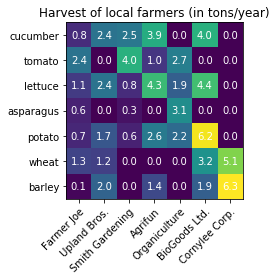

In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [ ]:
                
"""

"""


# Still to include Means and other things in this function from HAR-Copy4